In [1]:
import cv2
import numpy as np
import keyboard  # using module keyboard
#from time import sleep
import matplotlib.pyplot as plt
import win32gui, win32ui,win32con, win32api

# data collection

In [2]:
def get_screenshot(region=None):
    #hwnd = win32gui.FindWindow(None, window_name)
    hwnd = win32gui.GetDesktopWindow()
    if region:
        left, top, x2, y2 = region
        width = x2 - left + 1
        height = y2 - top + 1
    else:
        width = win32api.GetSystemMetrics(win32con.SM_CXVIRTUALSCREEN)
        height = win32api.GetSystemMetrics(win32con.SM_CYVIRTUALSCREEN)
        left = win32api.GetSystemMetrics(win32con.SM_XVIRTUALSCREEN)
        top = win32api.GetSystemMetrics(win32con.SM_YVIRTUALSCREEN)
    
    # get the window image data
    wDC = win32gui.GetWindowDC(hwnd)
    dcObj = win32ui.CreateDCFromHandle(wDC)
    cDC = dcObj.CreateCompatibleDC()
    dataBitMap = win32ui.CreateBitmap()
    dataBitMap.CreateCompatibleBitmap(dcObj, width, height)
    cDC.SelectObject(dataBitMap)
    cDC.BitBlt((0, 0), (width, height), dcObj, (left, top), win32con.SRCCOPY)

    # convert the raw data into a format opencv can read
    signedIntsArray = dataBitMap.GetBitmapBits(True)
    img = np.frombuffer(signedIntsArray, dtype='uint8')
    img.shape = (height, width, 4)

    # free resources
    dcObj.DeleteDC()
    cDC.DeleteDC()
    win32gui.ReleaseDC(hwnd, wDC)
    win32gui.DeleteObject(dataBitMap.GetHandle())

    img = np.ascontiguousarray(img)

    return img

In [ ]:
# continue previous training or start one:
image_data = []
target = []

In [8]:
# Loop over the frames

button_release = True

while True: 

    img = get_screenshot((15,412,820 , 860))
    # Handle the rendering of the images/video
    image = cv2.resize(img, (224, 224))
    image = cv2.Canny(image, threshold1=119, threshold2=250)
    #cv2.imshow('GameCap', image)
    
    #print(keyboard.is_pressed("right"), keyboard.is_pressed("up"), keyboard.is_pressed("left"), button_release)
    
    if keyboard.is_pressed("right") and button_release == True:
        print("You pressed right")
        button_release = False
        image_data.append(np.array(image))
        target.append('right')

    elif keyboard.is_pressed("up") and button_release == True:
        print("You pressed up")
        button_release = False
        image_data.append(np.array(image))
        target.append('up')
    
    elif keyboard.is_pressed("left") and button_release == True:
        print("You pressed left")
        button_release = False
        image_data.append(np.array(image))
        target.append('left')
        
    elif not (keyboard.is_pressed("right") or keyboard.is_pressed("up") or keyboard.is_pressed("left")):
        button_release = True
        
    if keyboard.is_pressed("q"):
        target = target[:-1]
        image_data = image_data[:-1]
        print(" -- End --")
        break

    # Cv2.waitkey  
    if cv2.waitKey(1) & 0xFF==ord('q'):
        break

# Close down the frame
#cv2.destroyAllWindowqs()

You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed left
You pressed right
You pressed right
You pressed right
You pressed right
You pressed left
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed left
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed left
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed left
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed right
You pressed left
You pressed right
You pressed righ

In [9]:
print(len(target))
print(len(image_data))

636
636


right


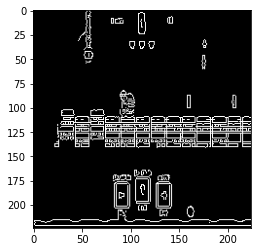

In [10]:
num = 0
print(target[num])
plt.imshow(image_data[num], cmap='gray')
plt.show()

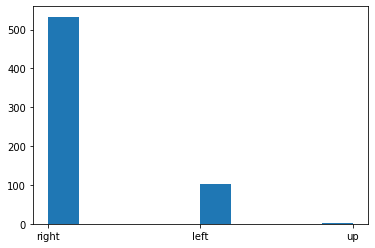

In [25]:
plt.hist(image_data)
plt.show()

In [24]:
# save data
np.save('data2.npy', np.array(image_data))
np.save('data/target2.npy', np.array(target))

# modeling and training

In [12]:
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet

In [2]:
from sklearn.metrics         import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from keras.models            import Sequential, Model
from keras.layers            import Conv2D, Dropout,MaxPooling2D,Dense, Flatten, Conv2DTranspose,\
Concatenate, BatchNormalization, Activation, GlobalAveragePooling2D, Concatenate
#from keras import Input
#from tensorflow.keras.layers import Input
#from keras.callbacks import Callback
#ºfrom tensorflow import keras
from tensorflow.keras import callbacks, optimizers

#from mlxtend.plotting import plot_confusion_matrix
from keras.models import Model
from keras.layers import Input 

In [3]:
def custom_model(input_shape=(224, 224,1,), n_out=1):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    #model.add(Dense(2, activation='softmax'))
    model.add(Dense(n_out, activation='sigmoid'))
    
    # compile model
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'], )

    return model

In [ ]:

resnet = Resnet50(weights='imagenet',include_top= 'TRUE') 

input_tensor = Input(shape=(IMG_SIZE,IMG_SIZE,1) )

x = Conv2D(3,(3,3),padding='same')(input_tensor)  # x has a dimension of (IMG_SIZE,IMG_SIZE,3)
out = resnet (x) 

model = Model(inputs=input_tensor,outputs=out)

In [ ]:
img_input = tf.keras.layers.Input(shape=(img_size_target, img_size_target,1))
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])    

model = ResNet50(include_top=True, weights='imagenet', input_tensor=img_conc)

In [15]:
def create_resnet50(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    
    if input_shape[2]==1:
        input_tensor = Concatenate()([input_tensor, input_tensor, input_tensor])

    base_model = ResNet50(weights='imagenet', 
                                       include_top=False,
                                       input_tensor=input_tensor)
    #base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    
    model = Model(input_tensor, final_output)

    #optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
    model.compile(optimizer="adam", loss="categorical_crossentropy",  metrics=["accuracy"])

    return model

In [16]:
def create_vgg16(input_shape, n_out):
    
    base_model = VGG16(
        weights="imagenet",
        include_top=False, 
        input_shape=input_shape
    )

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(n_out, activation='sigmoid'))

    
    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
        metrics=['accuracy']
    )
    return model

In [16]:
mdl_original = VGG16(weights="imagenet", include_top=False,  pooling='Max', input_shape=(224,224,3))

In [19]:
layer1_wb = mdl_original.layers[1].get_weights()

In [ ]:
# Custurmize VGG16 Network as Grayscale, 1024 Fully Connected

mdl_original = VGG16(classes=4, include_top=False,  pooling='Max', input_shape=(240,280,3))

layer1_wb = mdl_original.layers[1].get_weights()

layer1_w = layer1_wb[0]
layer1_w_newshape = list(layer1_w.shape)
layer1_w_newshape[2] = 1
layer1_w_newshape = tuple(layer1_w_newshape)

layer1_w_new = np.zeros(layer1_w_newshape)
layer1_w_new[:,:,0,:] = np.mean(layer1_w, axis=2)

layer1_new = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='block1_conv1')


layer1_wb_new = layer1_wb
layer1_wb_new[0] = layer1_w_new


img_input = Input(shape=(240,280,1))
# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1',use_bias=True)(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
x = GlobalMaxPooling2D()(x)

# Block 6
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dense(4, activation='softmax', name='predictions')(x)

mdl = Model(img_input, x)

In [17]:
def create_mobilenet(input_shape, n_out):

    input_tensor = Input(shape=input_shape)
    x3 = Conv2D(3,(3,3),padding='same')(input_tensor)  # x has a dimension of (IMG_SIZE,IMG_SIZE,3)
    
    base_model = MobileNet(input_shape = (224, 224,3), include_top = False,
                                               weights = "imagenet")
    
    x3_channels  = base_model (x3) 

    model = Sequential([x3_channels,
                                 GlobalAveragePooling2D(),
                                 Dense(20, activation = "relu"),
                                 Dropout(0.4),
                                 Dense(10, activation = "relu"),
                                 Dropout(0.3),
                                 Dense(n_out, activation = "sigmoid")                                     
                                ])
    model.compile(optimizer = keras.optimizers.Adam(lr = 1e-2), loss = "binary_crossentropy", metrics = ["accuracy"])
    return model

In [4]:
# train the rest of models:
models_dict = {"custom": custom_model(input_shape=(224, 224,1), n_out=3),
               #"resnet50": create_resnet50(input_shape=(224, 224, 3), n_out=3),
               #"vgg16": create_vgg16(input_shape=(224, 224,1), n_out=1),
               #"mobilenet": create_mobilenet(input_shape=(224, 224,1), n_out=3), 
              }

In [5]:
# read data
Y = np.load('data/target2.npy')
X = np.load('data/data2.npy')

In [6]:
X = X.reshape(-1, 224, 224, 1)
X = X/255

In [7]:
from sklearn.preprocessing import LabelEncoder
labeler = LabelEncoder()
Y = labeler.fit_transform(Y)

In [8]:
labeler.classes_

array(['left', 'right', 'up'], dtype='<U5')

In [9]:
from keras.utils.np_utils import to_categorical
Y = to_categorical(Y, num_classes=3)

In [10]:
seed = 19
X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
               train_size=0.9, test_size=0.1, random_state=seed)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(572, 224, 224, 1)
(572, 3)
(64, 224, 224, 1)
(64, 3)


In [12]:
models_history = {}
models_metrics = {}

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,  # minimium amount of change to count as an improvement
    patience=3,  # how many epochs to wait before stopping
    verbose=1
)

for model_name, model in models_dict.items():
    print("\n\n  Training model {}".format(model_name))

    # automatic data
    history = model.fit(x=X_train, y=y_train,
                        validation_data=(X_valid, y_valid,),
                        epochs=15,  
                        callbacks=[early_stopping])
    
    models_history[model_name] = history
    models_metrics[model_name] = model.evaluate(X_valid, np.array(y_valid))
    
    print("\nPredicting...")
    prediction= model.predict(X_valid, verbose=2)
    #print(plot_confusion_matrix(confusion_matrix(y_test, prediction), figsize=(5,5)))
    print(accuracy_score(np.argmax(y_valid, axis = 1), np.argmax(prediction, axis = 1)))
    print(classification_report(np.argmax(y_valid, axis = 1), np.argmax(prediction, axis = 1)))
    plt.show()
    
    print("\nDone\n")



  Training model custom
Epoch 1/15
18/18 [==============================] - 294s 17s/step - loss: 0.5497 - accuracy: 0.7255 - val_loss: 0.1886 - val_accuracy: 0.9219
Epoch 2/15
18/18 [==============================] - 348s 19s/step - loss: 0.3211 - accuracy: 0.8287 - val_loss: 0.2386 - val_accuracy: 0.9219
Epoch 3/15
18/18 [==============================] - 322s 18s/step - loss: 0.3123 - accuracy: 0.8287 - val_loss: 0.2100 - val_accuracy: 0.9219
Epoch 4/15
18/18 [==============================] - 315s 18s/step - loss: 0.3105 - accuracy: 0.8287 - val_loss: 0.2372 - val_accuracy: 0.9219
Epoch 00004: early stopping
2/2 [==============================] - 10s 5s/step - loss: 0.2372 - accuracy: 0.9219

Predicting...
2/2 - 11s


ValueError: Found input variables with inconsistent numbers of samples: [572, 64]

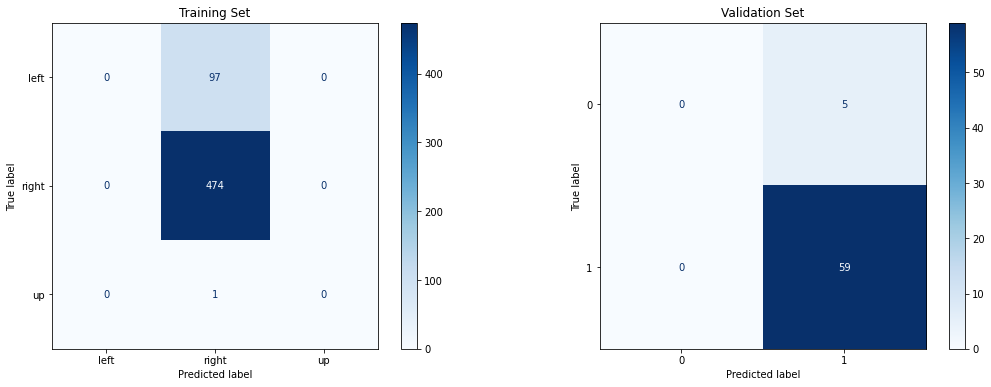

In [20]:
val_preds = np.argmax(model.predict(X_valid), axis = 1)
train_preds = np.argmax(model.predict(X_train), axis = 1)

fig, axes = plt.subplots(1, 2, figsize = (18, 6))

cm_train = confusion_matrix(np.argmax(y_train, axis = 1), train_preds)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels=labeler.classes_)
disp.plot(cmap = plt.cm.Blues, ax = axes[0])

cm_val = confusion_matrix(np.argmax(y_valid, axis = 1), val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_val)
disp.plot(cmap = plt.cm.Blues, ax = axes[1])

axes[0].set_title("Training Set"); 
axes[1].set_title("Validation Set")

plt.show()

custom
[0.2372303605079651, 0.921875]


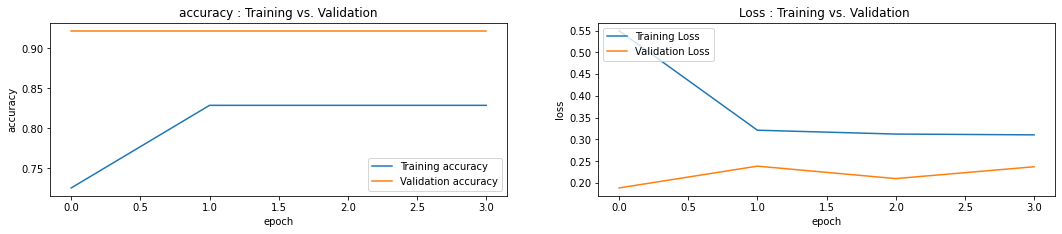

In [21]:
for key in models_history.keys():
    print(key)
    print(models_metrics[key])
    
    metric_name = "accuracy"
    plt.figure(figsize=(18, 7))
    plt.subplot(2, 2, 1)
    plt.plot(models_history[key].history[metric_name], label='Training {}'.format(metric_name))
    plt.plot(models_history[key].history['val_'+metric_name], label='Validation {}'.format(metric_name))
    plt.xlabel('epoch')
    plt.ylabel(metric_name)
    plt.legend(loc='lower right')
    plt.title('{} : Training vs. Validation'.format(metric_name))

    plt.subplot(2, 2, 2)
    plt.plot(models_history[key].history['loss'], label='Training Loss')
    plt.plot(models_history[key].history['val_loss'], label='Validation Loss')
    plt.title('Loss : Training vs. Validation ')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper left')
    plt.show()